<a href="https://colab.research.google.com/github/Fbehr-data/Radiant-Earth-Spot-Crop/blob/script_spectral/Random_forest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random_Forest model notebook
*by Anitha*

In this notebook I will  create a Random forest model from the baseline model .
The first step is to connect the Google Drive, import the modules and load the data. 

In [ ]:
#Connect the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the modules, set the working directories and load the data.

In [51]:
# Import the needed modules
import numpy as np
import pandas as pd
from matplotlib import pyplot
#!pip install rasterio
import seaborn as sns
from scipy import stats 
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import hyperopt.pyll.stochastic
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    log_loss, 
    confusion_matrix, 
    classification_report
    )
from IPython.core.pylabtools import figsize
%matplotlib inline
from sklearn.decomposition import PCA

In [3]:
 # Set the directory of the data 
OUTPUT_DIR = '../data'
# Load the base data from the CSV files
df_train = pd.read_csv(f'{OUTPUT_DIR}/Train_Dataset.csv')
df_test = pd.read_csv(f'{OUTPUT_DIR}/Test_Dataset.csv')

In [4]:
df_train

,B05_10,B05_11,B05_5,B05_6,B05_7,B05_8,B05_9,homogeneity_10,homogeneity_11,homogeneity_5,...,B08_11,B08_5,B08_6,B08_7,B08_8,B08_9,field_id,field_size,tile_id,label
0,47.066226,60.103753,54.878586,43.344370,39.947021,35.663575,35.432672,0.400000,0.000000,0.500000,...,81.196470,68.816779,60.788080,84.348785,93.150994,97.092715,4,151,2526,8
1,48.382919,79.578805,54.212733,45.037269,40.535197,38.800078,33.677796,0.413707,0.485758,0.503335,...,94.514750,58.161490,54.506212,64.888199,88.352097,91.444875,14,644,979,8
2,93.371714,94.650908,90.118740,90.782387,87.399483,66.465379,78.149913,0.481771,0.508425,0.551671,...,109.695809,100.468482,106.841680,111.835061,95.225623,100.387565,20,579,632,8
3,56.779761,60.005952,45.738096,49.928570,41.966666,53.912699,54.015873,0.497820,0.389199,0.346870,...,72.660715,54.000000,62.452380,52.842857,65.865080,66.952380,25,42,1779,3
4,41.873684,56.456141,45.921054,33.447370,37.403509,39.526316,45.999999,0.430394,0.424396,0.424946,...,72.543862,66.065790,68.184213,82.324560,91.350873,64.526313,40,38,229,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44576,68.203273,64.634365,59.737983,51.271318,55.125970,52.986219,43.156589,0.399245,0.390108,0.366199,...,79.904392,73.469766,68.263570,78.359495,82.403963,64.767442,122575,129,328,5
44577,96.803281,101.964194,75.599474,71.964670,83.225678,84.604493,90.699685,0.409268,0.398346,0.422811,...,110.664669,81.275605,85.056782,95.474134,95.039117,102.597789,122598,1585,1866,5
44578,67.314020,73.899668,62.488168,59.667926,56.018963,46.473018,61.661671,0.436372,0.445108,0.454173,...,85.550357,70.924150,74.264360,80.354241,71.538568,83.278091,122628,1851,1289,5
44579,69.728487,73.202357,60.672560,57.299608,60.242140,34.879175,63.662739,0.434653,0.426423,0.386597,...,87.736248,68.734774,68.833985,76.796169,47.727897,86.475440,122662,509,2434,5


## Randomforest Model

For our model, we only worked on the mean bands for each field and each month and chose a RandomForest classifier, as this is a commonly used model for raster data. 

We chose the F1 score and Accuracy as metrics, since the main goal is to correctly identify as many plants as possible. Neither FP nor FN are particularly bad or good, hence the harmonic mean F1. In addition, we also have an eye on the cross-entropy, because later we will deal with the probabilities with which a class is assigned to a field. 

Here we don't need to do the train-test-split of the data because we already have two dataset the train dataset and the testdataset .

In [5]:
# Set a random seed
RSEED = 42
np.random.seed(RSEED)

In [6]:

# get X for the train and validation data
X_train = df_train.drop(columns=["label", "field_id"])
X_val = df_test.drop(columns=["label", "field_id"])

# get y for the train and validation data
y_train = df_train["label"]
y_train = y_train.astype(int)
y_val = df_test["label"]
y_val = y_val.astype(int)

# set the class labels from 0 to 8 
y_train = y_train-1
y_val = y_val-1

In [7]:
df_train.shape

(44581, 165)

In [8]:
df_test.shape

(24043, 165)

In [9]:
labels = y_train.unique()

Here is the baseline model 

In [52]:

# Fitting the RF model
rf = RandomForestClassifier(n_estimators = 200, random_state = RSEED, n_jobs = -1, verbose=1,max_features='auto', max_depth=10, criterion='entropy')
rf.fit(X_train, y_train)

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.6s finished


RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [11]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


In [12]:
y_proba_train = rf.predict_proba(X_train)
y_proba_test = rf.predict_proba(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


And the results of our baseline model. 

In [13]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_pred_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_pred_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_pred_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.7014871806374913
Accuracy on test data: 0.6298714802645261
------------------------------
F1-score on train data: 0.6968103476049269
F1-score on test data: 0.5703836174480637
------------------------------
Cross-entropy on train data: 0.9861705288263142
Cross-entropy on test data: 1.0994882455592394
------------------------------


In [ ]:
df_train.columns.shape

(65,)

## hyperparameter tuning 
we are going to do the modelling by trying out a wide range of parameters and see what works! the main goal is to fight the overfitting.
We will try adjusting the following set of hyperparameters:
* n_estimators = number of trees in the foreset

* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node


In [14]:
from sklearn.ensemble import RandomForestClassifier
# Fitting the RF model
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1, verbose=1,max_features='auto', max_depth=20, criterion='gini',min_samples_split=80, min_samples_leaf=50)
rf.fit(X_train, y_train)

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished


RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=50,
                       min_samples_split=80, n_estimators=200, n_jobs=-1,
                       random_state=42, verbose=1)

In [15]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [16]:
y_proba_train = rf.predict_proba(X_train)
y_proba_test = rf.predict_proba(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


Result of hyperparameter tuning

In [17]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_pred_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_pred_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_pred_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.6213409299925977
Accuracy on test data: 0.6201389177723245
------------------------------
F1-score on train data: 0.61630042414292
F1-score on test data: 0.5619255297694289
------------------------------
Cross-entropy on train data: 1.148121289421195
Cross-entropy on test data: 1.1467703155835443
------------------------------


## Hyperparameter tuning via Bayesian optimization

1st Round 

In [18]:
# hp.uniform for float number
# hp.quniform for int that are a multiple from the last number, 
# for example 3, 15, 1 means any whole number between 3 and 15


space={
    'criterion': hp.choice('criterion',('gini', 'entropy')),
    'n_estimators': hp.quniform('n_estimators', 200, 800,100),
    'random_state': RSEED,
    'bootstrap':hp.choice('bootstrap',('True', 'False')),
    'max_features':hp.choice('max_features',('auto', 'sqrt')),
    'min_samples_leaf': hp.quniform('min_samples_leaf',20, 60,10),
    'max_depth': hp.quniform('max_depth', 10, 40,5),
    'min_samples_split':hp.quniform('min_samples_split',20, 80,10),
    }
print(hyperopt.pyll.stochastic.sample(space))

{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 20.0, 'max_features': 'auto', 'min_samples_leaf': 50.0, 'min_samples_split': 30.0, 'n_estimators': 500.0, 'random_state': 42}


In [20]:
def objective(space):
    rfc = RandomForestClassifier(
        criterion =space['criterion'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        bootstrap =space['bootstrap'],
        max_features =space['max_features'],
         min_samples_leaf=int(space['min_samples_leaf']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']) 
        )
    
    evaluation = [
                  ( X_train, y_train), 
                  ( X_val, y_val)
    ]
                
    rfc.fit(
        X_train, y_train
        )
    
    y_pred_val = rfc.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [21]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                
0.5553103453055095                                    
SCORE:                                                                            
0.5713533505686709                                                                
  7%|▋         | 2/30 [03:33<48:32, 104.03s/trial, best loss: -0.5713533505686709]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                            
0.563198140758371                                                                 
SCORE:                                                                            
0.5668331673060165                                                                
SCORE:                                                                            
0.57445767792288                                                                  
SCORE:                                                                            
0.5621094560713678                                                              
SCORE:                                                                          
0.5737030448151532                                                             
 23%|██▎       | 7/30 [13:30<47:19, 123.47s/trial, best loss: -0.57445767792288]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                          
0.569513751716467                                                               
SCORE:                                                                          
0.5669430557682134                                                              
SCORE:                                                                          
0.5593472923856062                                                              
SCORE:                                                                             
0.5730628628857539                                                                 
SCORE:                                                                             
0.5626270554666142                                                               
SCORE:                                                                           
0.5591395921302016                                                               
 43%|████▎     |

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                             
0.5668331673060165                                                                 
SCORE:                                                                             
0.5615134411393771                                                               
SCORE:                                                                           
0.566295156663281                                                                
 53%|█████▎    | 16/30 [39:54<31:21, 134.36s/trial, best loss: -0.57445767792288]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                           
0.5727811631309147                                                               
SCORE:                                                                           
0.5808212418359835                                                               
 60%|██████    | 18/30 [45:26<31:27, 157.31s/trial, best loss: -0.5808212418359835]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                             
0.5670476952343297                                                                 
 63%|██████▎   | 19/30 [47:19<26:25, 144.18s/trial, best loss: -0.5808212418359835]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                             
0.5623410565741644                                                                 
SCORE:                                                                             
0.5712838351628963                                                                 
SCORE:                                                                             
0.5583226932028753                                                                 
SCORE:                                                                             
0.5681908337170902                                                                   
SCORE:                                                                               
0.5809525113619523                                                                   
SCORE:                                                                               
0.5809525113619523                                                  

In [22]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'bootstrap': 0, 'criterion': 1, 'max_depth': 40.0, 'max_features': 1, 'min_samples_leaf': 20.0, 'min_samples_split': 20.0, 'n_estimators': 400.0}


In [35]:
best= RandomForestClassifier(n_estimators=400,
                                                    min_samples_split = 20,
                                                    min_samples_leaf = 20,
                                                    max_features = 'sqrt',
                                                    max_depth = 40,
                                                    bootstrap = 'True',
                                                    criterion = 'entropy'
                                                    )

In [36]:
best.fit(X_train, y_train)

RandomForestClassifier(bootstrap='True', criterion='entropy', max_depth=40,
                       min_samples_leaf=20, min_samples_split=20,
                       n_estimators=400)

In [37]:
y_predu_train = best.predict(X_train)
y_predu_test = best.predict(X_val)
y_probab_train = best.predict_proba(X_train)
y_probab_test = best.predict_proba(X_val)

In [38]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_predu_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predu_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predu_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predu_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_probab_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_probab_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.704470514344676
Accuracy on test data: 0.636942145322963
------------------------------
F1-score on train data: 0.7010242617038853
F1-score on test data: 0.5803360463772063
------------------------------
Cross-entropy on train data: 0.9645050796747167
Cross-entropy on test data: 1.08426036343387
------------------------------


2nd Round

In [27]:

space={
    'criterion': hp.choice('criterion',('gini', 'entropy')),
    'n_estimators': hp.quniform('n_estimators', 200,2000,200),
    'random_state': RSEED,
    'bootstrap':hp.choice('bootstrap',('True', 'False')),
    'max_features':hp.choice('max_features',('auto', 'sqrt')),
    'min_samples_leaf': hp.quniform('min_samples_leaf',4,6,2),
    'max_depth': hp.quniform('max_depth', 10, 110,11),
    'min_samples_split':hp.quniform('min_samples_split',10,25,5),
    }
print(hyperopt.pyll.stochastic.sample(space))

{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 88.0, 'max_features': 'sqrt', 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 2000.0, 'random_state': 42}


In [28]:
def objective(space):
    rfc = RandomForestClassifier(
        criterion =space['criterion'],
        n_estimators=int(space['n_estimators']),
        random_state=space['random_state'],
        bootstrap =space['bootstrap'],
        max_features =space['max_features'],
         min_samples_leaf=int(space['min_samples_leaf']),
        max_depth=int(space['max_depth']),
        min_samples_split=int(space['min_samples_split']) 
        )
    
    evaluation = [
                  ( X_train, y_train), 
                  ( X_val, y_val)
    ]
                
    rfc.fit(
        X_train, y_train
        )
    
    y_pred_val = rfc.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average="macro")
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

In [29]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                
0.6158523635357199                                    
  3%|▎         | 1/30 [07:25<3:35:13, 445.31s/trial, best loss: -0.6158523635357199]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                              
0.612142859874383                                                                   
  7%|▋         | 2/30 [19:42<4:47:58, 617.08s/trial, best loss: -0.6158523635357199]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                              
0.600383269669796                                                                   
SCORE:                                                                              
0.6011989010416241                                                                  
SCORE:                                                                              
0.6091333476043646                                                                  
 17%|█▋        | 5/30 [55:10<4:27:32, 642.11s/trial, best loss: -0.6158523635357199]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                              
0.6176497613913643                                                                    
 20%|██        | 6/30 [1:06:20<4:20:38, 651.61s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                
0.6039213849710765                                                                    
SCORE:                                                                                
0.610653856842545                                                                     
 27%|██▋       | 8/30 [1:25:08<3:56:25, 644.81s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                
0.6104494534821303                                                                    
 30%|███       | 9/30 [1:32:11<3:21:24, 575.45s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                
0.610738811591218                                                                     
 33%|███▎      | 10/30 [1:45:02<3:31:54, 635.71s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                 
0.5999619362778452                                                                     
SCORE:                                                                                 
0.6170985740009979                                                                     
SCORE:                                                                                 
0.6045637333607969                                                                     
 43%|████▎     | 13/30 [2:01:31<2:07:55, 451.50s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                 
0.6017665496718846                                                                     
SCORE:                                                                                 
0.6034319648730052                                                                     
SCORE:                                                                                 
0.6072596855278072                                                                     
SCORE:                                                                                 
0.6125768088723732                                                                     
SCORE:                                                                                 
0.6089712212117988                                                                   
 60%|██████    | 18/30 [2:20:09<51:27, 257.33s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                               
0.5796899415573852                                                                   
SCORE:                                                                                 
0.6001816606600661                                                                     
SCORE:                                                                                 
0.6170985740009979                                                                   
 70%|███████   | 21/30 [2:42:51<58:26, 389.65s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                               
0.6171210725306586                                                                   
 73%|███████▎  | 22/30 [2:58:24<1:13:41, 552.63s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                 
0.5831216329954934                                                                     
 77%|███████▋  | 23/30 [3:11:21<1:12:21, 620.14s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                 
0.6171210725306586                                                                     
 80%|████████  | 24/30 [3:26:39<1:10:55, 709.33s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                 
0.6172431794135198                                                                     
 83%|████████▎ | 25/30 [3:39:52<1:01:12, 734.45s/trial, best loss: -0.6176497613913643]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                                 
0.6184291547927909                                                                     
 87%|████████▋ | 26/30 [3:53:05<50:08, 752.15s/trial, best loss: -0.6184291547927909]  

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                               
0.6093319117097288                                                                   
 90%|█████████ | 27/30 [4:00:27<32:56, 658.96s/trial, best loss: -0.6184291547927909]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                               
0.6172431794135198                                                                   
 93%|█████████▎| 28/30 [4:13:30<23:12, 696.18s/trial, best loss: -0.6184291547927909]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                               
0.5839565392128282                                                                   
 97%|█████████▋| 29/30 [4:22:58<10:57, 657.75s/trial, best loss: -0.6184291547927909]

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



SCORE:                                                                               
0.618760221467813                                                                    
100%|██████████| 30/30 [4:39:43<00:00, 559.44s/trial, best loss: -0.618760221467813] 


In [30]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'bootstrap': 1, 'criterion': 1, 'max_depth': 22.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 1800.0}


In [31]:
best= RandomForestClassifier(n_estimators=1800,
                                                    min_samples_split = 10,
                                                    min_samples_leaf = 4,
                                                    max_features = 'auto',
                                                    max_depth = 22,
                                                    bootstrap = 'False',
                                                    criterion = 'entropy')

In [32]:
best.fit(X_train, y_train)

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap='False', criterion='entropy', max_depth=22,
                       max_features='auto', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1800)

In [40]:
y_predu_train = best.predict(X_train)
y_predu_test = best.predict(X_val)
y_probab_train = best.predict_proba(X_train)
y_probab_test = best.predict_proba(X_val)

In [41]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_predu_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predu_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predu_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predu_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_probab_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_probab_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 0.704470514344676
Accuracy on test data: 0.636942145322963
------------------------------
F1-score on train data: 0.7010242617038853
F1-score on test data: 0.5803360463772063
------------------------------
Cross-entropy on train data: 0.9645050796747167
Cross-entropy on test data: 1.08426036343387
------------------------------


## Random Hyperparameter Grid
To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Now, we instantiate the random search and fit it

In [43]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(n_estimators = 200, random_state = RSEED, n_jobs = -1, verbose=1,max_features='auto', max_depth=10, criterion='entropy')
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   16.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  16.3s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  15.2s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   16.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  16.7s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:   24.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 235 out of 235 | elapsed:    0.2s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=235; total time=  24.5s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:   24.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 235 out of 235 | elapsed:    0.2s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=235; total time=  25.2s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:   26.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 235 out of 235 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=235; total time=  27.2s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=74; total time=  13.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=74; total time=  13.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=74; total time=  14.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:   47.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 267 out of 267 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=267; total time=  47.7s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:   49.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 267 out of 267 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=267; total time=  49.5s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:   49.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 267 out of 267 | elapsed:    0.2s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=267; total time=  50.1s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   25.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=138; total time=  25.8s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   25.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=138; total time=  25.6s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   26.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 138 out of 138 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=138; total time=  26.5s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   10.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=74; total time=  11.0s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   10.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=74; total time=  11.0s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=74; total time=  11.1s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=74; total time=  14.0s


/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.0s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=74; total time=  14.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  74 out of  74 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=74; total time=  14.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:   48.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 267 out of 267 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=267; total time=  48.6s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:   47.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 267 out of 267 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=267; total time=  48.2s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 267 out of 267 | elapsed:   49.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 267 out of 267 | elapsed:    0.2s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=267; total time=  49.8s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   19.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  19.6s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   19.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:    0.1s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  19.4s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 171 out of 171 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=171; total time=  21.1s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  35.2s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  35.4s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished
/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  36.9s


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   42.8s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_depth=10,
                                                    max_features='auto',
                                                    n_estimators=200, n_jobs=-1,
                                                    random_state=42,
                                                    verbose=1),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300]},
                   verbose=2)

We can view the best parameters from fitting the random search ,from these results we will do our best model

In [44]:
best_random = rf_random.best_params_
best_random

{'n_estimators': 138,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [45]:
best= RandomForestClassifier(n_estimators=138,
                                                    min_samples_split = 2,
                                                    min_samples_leaf = 2,
                                                    max_features = 'auto',
                                                    max_depth = 40,
                                                    bootstrap = False)

In [46]:
best.fit(X_train, y_train)

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=40, max_features='auto',
                       min_samples_leaf=2, n_estimators=138)

In [47]:
y_predi_train = best.predict(X_train)
y_predi_test = best.predict(X_val)

In [48]:
y_proba_train = best.predict_proba(X_train)
y_proba_test = best.predict_proba(X_val)

Here is the Result using RandomizedsearchCV , comparing with the result of the baseline model ,we can see that the scores increased but still overfitting 

In [49]:

print(f'Accuracy on train data: {accuracy_score(y_train, y_predi_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predi_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predi_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predi_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 1.0
Accuracy on test data: 0.6824855467287776
------------------------------
F1-score on train data: 1.0
F1-score on test data: 0.6377529200149794
------------------------------
Cross-entropy on train data: 0.11822818438260406
Cross-entropy on test data: 0.9819705741280415
------------------------------


## Error Analysis 


## Feature Importance 
We want to take a look in the features we have and see which one are really important ,To get the feature importances from the Random Forest model use the feature_importances_ attribute

In [53]:
# feature importance of the baseline model
feature_imp = pd.Series(rf.feature_importances_,X_train.columns).sort_values(ascending=False)
feature_imp

NDVI_11           0.041934
SIPI2_11          0.037093
NDRE_11           0.030896
NDVI_5            0.028417
NDRE_8            0.028008
                    ...   
correlation_11    0.000744
correlation_6     0.000720
correlation_5     0.000709
correlation_7     0.000709
correlation_10    0.000706
Length: 163, dtype: float64

Let’s plot the importances (chart will be easier to interpret than values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


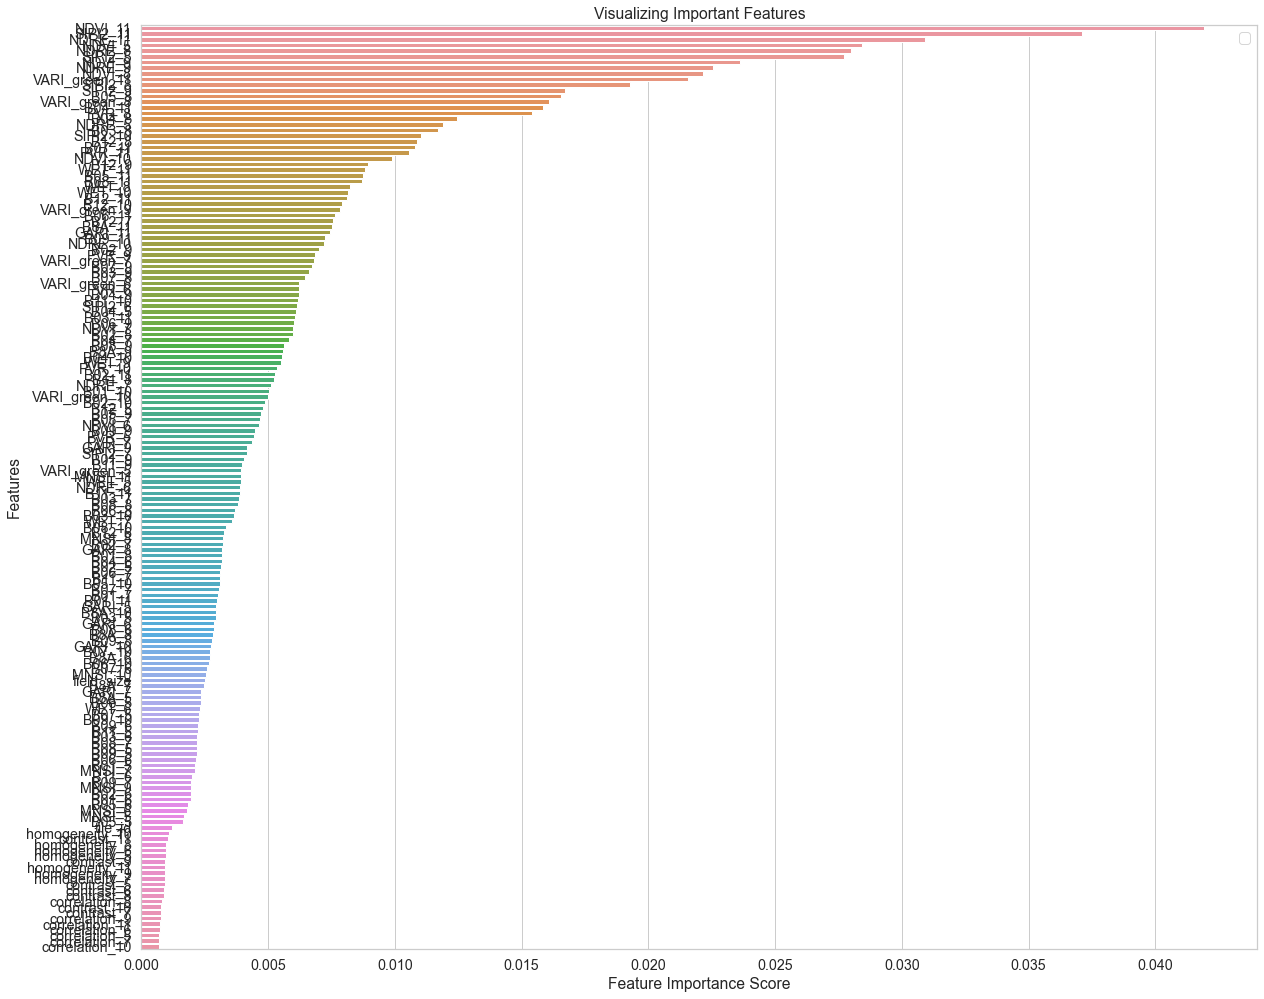

In [54]:

# Creating a bar plot
cmap =sns.color_palette('crest')
plt.figure(figsize = (20, 17))
sns.set(style="whitegrid", font_scale = 1.3)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

We observe that, the six index features are found most important

### Confusion matrix

In [55]:
# View confusion matrix for test data and predictions
confusion_matrix(y_val, y_predi_test)

array([[1255,  400,  101,  103,  116,  206,   66,   20],
       [ 303, 2232,   98,  169,  439,  299,   53,   83],
       [  87,  147, 1271,  140,  351,  109,   16,  143],
       [  80,  338,  134, 5491,   86,   47,   19,   24],
       [  65,  239,  337,   91, 1338,   73,    7,  181],
       [ 243,  237,  126,   19,  157, 1237,  314,   63],
       [  99,   66,   48,    8,   32,  310, 2577,   29],
       [  81,  104,  118,   10,  220,  105,   75, 1008]])

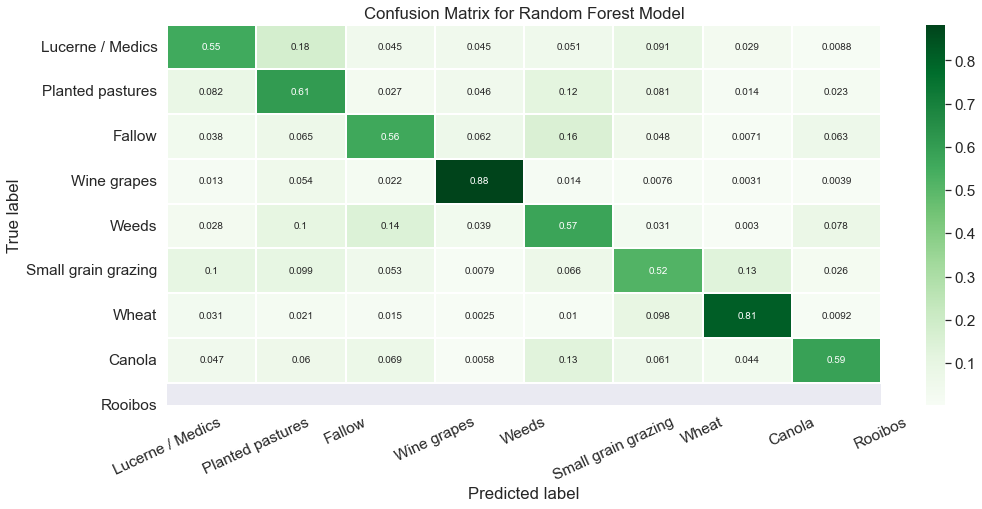

In [56]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_predi_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lucerne / Medics', 'Planted pastures', 'Fallow', 
               'Wine grapes', 'Weeds', 'Small grain grazing',    
               'Wheat','Canola','Rooibos']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## Principal Components Analysis(PCA)
Using dimension reduction, we can approximate the original dataset with fewer variables, while reducing computational power to run our model. Using PCA.

In [57]:
X_train.shape

(44581, 163)

In [58]:
X_train.columns

Index(['B05_10', 'B05_11', 'B05_5', 'B05_6', 'B05_7', 'B05_8', 'B05_9',
       'homogeneity_10', 'homogeneity_11', 'homogeneity_5',
       ...
       'B04_9', 'B08_10', 'B08_11', 'B08_5', 'B08_6', 'B08_7', 'B08_8',
       'B08_9', 'field_size', 'tile_id'],
      dtype='object', length=163)

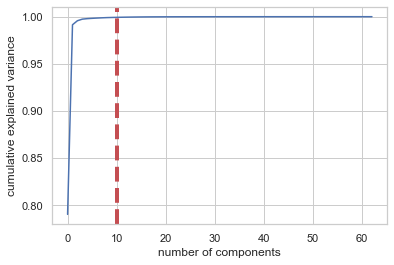

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.790218,0.790218
1,0.991440,0.201222
2,0.995702,0.004262
3,0.997401,0.001699
4,0.997929,0.000529
5,0.998268,0.000339
6,0.998550,0.000281
7,0.998813,0.000263
8,0.999028,0.000215
9,0.999176,0.000148


In [59]:

pca_test = PCA(n_components=63)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

20 Principal Components explain the most variance.on plot we can see that after 20 components there is no variance.So by using PCA, the dimensions are reduces from 63 to 10

In [62]:
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

Each component is a linear combination of the original variables with corresponding “weights”. We can see these “weights” for each PCA component by creating a dataframe.

In [63]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=X_train.columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
B05_10,0.001393,-0.000410,0.128155,-0.023663,0.027918,-0.061746,0.076369,-0.013230,0.108402,-0.015714
B05_11,0.001770,-0.000430,0.122670,0.002200,0.047183,-0.093595,0.061790,-0.053242,0.153647,-0.136840
B05_5,0.002015,-0.000637,0.120573,0.038046,-0.087185,-0.034005,-0.192628,-0.006937,0.083485,0.041115
B05_6,0.001654,-0.000329,0.112872,0.028942,-0.046725,0.192095,-0.024744,-0.186521,-0.015780,-0.105322
B05_7,0.001223,-0.000094,0.119288,-0.025116,0.017272,0.002155,-0.030258,-0.060551,-0.075564,0.049637
...,...,...,...,...,...,...,...,...,...,...
B08_7,0.001377,-0.000775,0.091206,0.159501,-0.051766,0.054160,0.102356,0.120934,-0.043301,0.065535
B08_8,0.001982,-0.000952,0.052717,0.258383,-0.036920,-0.078822,0.118428,-0.060736,-0.023638,0.116292
B08_9,0.000905,-0.000817,0.061752,0.148802,0.152460,-0.092319,-0.034272,-0.135385,-0.069935,0.044593
field_size,0.999822,0.012852,-0.011428,-0.004495,0.004910,0.002602,0.000076,0.001424,0.000348,0.001591


Now, we can fit our X_train_scaled_pca and y_train data to the Random Forest model, to see if we get any improvement on the model’s predictions.

In [64]:
rfc = RandomForestClassifier(n_estimators=42,
                                                    min_samples_split = 2,
                                                    min_samples_leaf = 2,
                                                    max_features = 'auto',
                                                    max_depth = 30,
                                                    bootstrap = False)
rfc.fit(X_train_pca, y_train)
#display(rfc.score(X_train_pca, y_train))

/Users/anithagrace/neue_fische/Radiant-Earth-Spot-Crop/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=30, max_features='auto',
                       min_samples_leaf=2, n_estimators=42)

In [65]:
y_predi_train = rfc.predict(X_train_pca)
y_predi_test = rfc.predict(X_val_pca)

In [66]:
y_proba_train = rfc.predict_proba(X_train_pca)
y_proba_test = rfc.predict_proba(X_val_pca)

From this result we can see no much improvement to avoid the overfitting

In [67]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

print(f'Accuracy on train data: {accuracy_score(y_train, y_predi_train)}')
print(f'Accuracy on test data: {accuracy_score(y_val, y_predi_test)}')
print('---'*10)
print(f'F1-score on train data: {f1_score(y_train, y_predi_train, average="macro")}')
print(f'F1-score on test data: {f1_score(y_val, y_predi_test, average="macro")}')
print('---'*10)
print(f'Cross-entropy on train data: {log_loss(y_train, y_proba_train, labels=labels)}')
print(f'Cross-entropy on test data: {log_loss(y_val, y_proba_test, labels=labels)}')
print('---'*10)

Accuracy on train data: 1.0
Accuracy on test data: 0.565777981117165
------------------------------
F1-score on train data: 1.0
F1-score on test data: 0.5140510271027192
------------------------------
Cross-entropy on train data: 0.1917603378944284
Cross-entropy on test data: 1.4126442615359547
------------------------------
